In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier

## Reading Data

In [2]:
data1 = pd.read_csv("Heart_Attack_Analysis_Data.csv")
data1 = pd.DataFrame(data1)

In [3]:
data1.head()

,Age,Sex,CP_Type,BloodPressure,Cholestrol,BloodSugar,ECG,MaxHeartRate,ExerciseAngia,FamilyHistory,Target
0,63,1,3,145,233,1,0,150,0,2,1
1,37,1,2,130,250,0,1,187,0,1,1
2,41,0,1,130,204,0,0,172,0,0,1
3,56,1,1,120,236,0,1,178,0,1,1
4,57,0,0,120,354,0,1,163,1,0,1


## Exploring Data

In [4]:
data1.shape

(303, 11)

In [5]:
#Check duplicate rows in data
duplicate_rows = data1[data1.duplicated()]
print("Number of duplicate rows :: ", duplicate_rows.shape)

Number of duplicate rows ::  (0, 11)


In [6]:
#looking for null values
print("Null values :: ")
print(data1.isnull() .sum())

Null values :: 
Age              0
Sex              0
CP_Type          0
BloodPressure    0
Cholestrol       0
BloodSugar       0
ECG              0
MaxHeartRate     0
ExerciseAngia    0
FamilyHistory    0
Target           0
dtype: int64


In [7]:
#Explore if the other data is consistent
data1.shape

(303, 11)

In [8]:
data1.columns

Index(['Age', 'Sex', 'CP_Type', 'BloodPressure', 'Cholestrol', 'BloodSugar',
       'ECG', 'MaxHeartRate', 'ExerciseAngia', 'FamilyHistory', 'Target'],
      dtype='object')

##### Analyzing the impact of feature on target label for all the feature below and trying to know the impact and contribution rate for objective

In [9]:
data1.groupby('Target')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,138.0,56.601449,7.962082,35.0,52.0,58.0,62.0,77.0
1,165.0,52.496970,9.550651,29.0,44.0,52.0,59.0,76.0


In [10]:
data1.groupby('Target')['BloodPressure'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,138.0,134.398551,18.729944,100.0,120.0,130.0,144.75,200.0
1,165.0,129.303030,16.169613,94.0,120.0,130.0,140.00,180.0


In [11]:
data1.groupby('Target')['Cholestrol'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,138.0,251.086957,49.454614,131.0,217.25,249.0,283.0,409.0
1,165.0,242.230303,53.552872,126.0,208.00,234.0,267.0,564.0


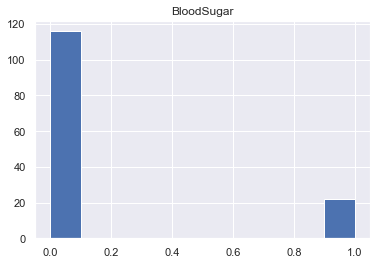

In [12]:
data1_temp=data1[data1['Target']==0][['BloodSugar']].hist()

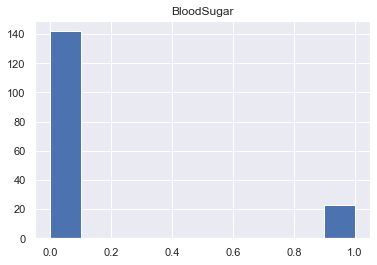

In [13]:
data1_temp=data1[data1['Target']==1][['BloodSugar']].hist()

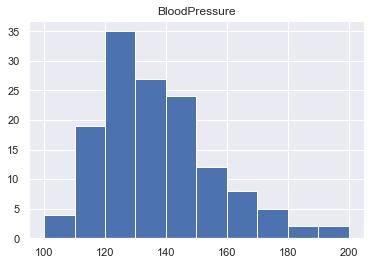

In [14]:
data1_temp=data1[data1['Target']==0][['BloodPressure']].hist()

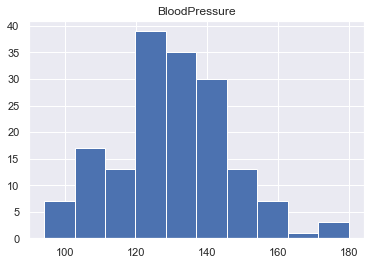

In [15]:
data1_temp=data1[data1['Target']==1][['BloodPressure']].hist()

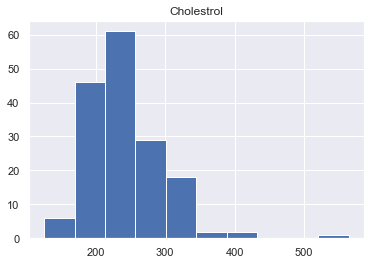

In [16]:
data1_temp=data1[data1['Target']==1][['Cholestrol']].hist()

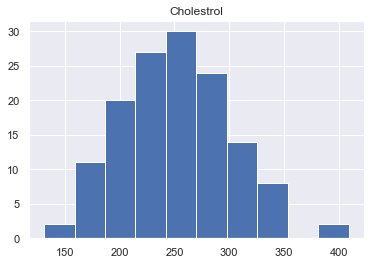

In [17]:
ata1_temp=data1[data1['Target']==0][['Cholestrol']].hist()

In [18]:
# Calculate information value
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Bad 
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Good (Approved) 

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Bad', 'Good'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('This variable\'s IV is:',iv)
    print(df[feature].value_counts())
    return iv, data

In [19]:
iv, data = calc_iv(data1,'BloodSugar','Target')

This variable's IV is: 0.003159859788729567
0    258
1     45
Name: BloodSugar, dtype: int64


In [20]:
data

,Variable,Value,All,Bad,Good,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,BloodSugar,0,258,116,142,0.851485,0.449612,0.860606,0.84058,0.023545,0.000472
1,BloodSugar,1,45,22,23,0.148515,0.488889,0.139394,0.15942,-0.134240,0.002688


In [21]:
iv, data = calc_iv(data1,'ECG','Target')
data

This variable's IV is: 0.13614115238253202
1    152
0    147
2      4
Name: ECG, dtype: int64


,Variable,Value,All,Bad,Good,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,ECG,0,147,79,68,0.485149,0.537415,0.412121,0.572464,-0.328632,0.052694
1,ECG,1,152,56,96,0.501650,0.368421,0.581818,0.405797,0.360305,0.063421
2,ECG,2,4,3,1,0.013201,0.750000,0.006061,0.021739,-1.277304,0.020026


In [22]:
iv, data = calc_iv(data1,'BloodPressure','Target')
data.head()

This variable's IV is: 0.2909243126578178
120    37
130    36
140    32
110    19
150    17
138    13
128    12
125    11
160    11
112     9
132     8
118     7
135     6
108     6
124     6
145     5
134     5
152     5
122     4
170     4
100     4
142     3
115     3
136     3
105     3
180     3
126     3
102     2
94      2
144     2
178     2
146     2
148     2
129     1
165     1
101     1
174     1
104     1
172     1
106     1
156     1
164     1
192     1
114     1
155     1
117     1
154     1
123     1
200     1
Name: BloodPressure, dtype: int64


C:\Users\sariya.ansari\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Variable,Value,All,Bad,Good,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,BloodPressure,94,2,0,2,0.006601,0.0,0.012121,0.000000,0.000000,0.000000
1,BloodPressure,100,4,2,2,0.013201,0.5,0.012121,0.014493,-0.178692,0.000424
2,BloodPressure,101,1,0,1,0.003300,0.0,0.006061,0.000000,0.000000,0.000000
3,BloodPressure,102,2,0,2,0.006601,0.0,0.012121,0.000000,0.000000,0.000000
4,BloodPressure,104,1,0,1,0.003300,0.0,0.006061,0.000000,0.000000,0.000000


In [23]:
iv, data = calc_iv(data1,'CP_Type','Target')
data.head()

This variable's IV is: 1.2101259382105385
0    143
2     87
1     50
3     23
Name: CP_Type, dtype: int64


,Variable,Value,All,Bad,Good,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,CP_Type,0,143,104,39,0.471947,0.727273,0.236364,0.753623,-1.159521,0.599773
1,CP_Type,1,50,9,41,0.165017,0.180000,0.248485,0.065217,1.337656,0.245149
2,CP_Type,2,87,18,69,0.287129,0.206897,0.418182,0.130435,1.165043,0.335238
3,CP_Type,3,23,7,16,0.075908,0.304348,0.096970,0.050725,0.647987,0.029966


In [24]:
iv, data = calc_iv(data1,'Cholestrol','Target')
data.head()

This variable's IV is: 0.17582956080357318
234    6
204    6
197    6
269    5
212    5
      ..
278    1
281    1
284    1
290    1
564    1
Name: Cholestrol, Length: 152, dtype: int64


C:\Users\sariya.ansari\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Variable,Value,All,Bad,Good,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Cholestrol,126,1,0,1,0.003300,0.0,0.006061,0.000000,0.000000,0.000000
1,Cholestrol,131,1,1,0,0.003300,1.0,0.000000,0.007246,0.000000,-0.000000
2,Cholestrol,141,1,0,1,0.003300,0.0,0.006061,0.000000,0.000000,0.000000
3,Cholestrol,149,2,1,1,0.006601,0.5,0.006061,0.007246,-0.178692,0.000212
4,Cholestrol,157,1,0,1,0.003300,0.0,0.006061,0.000000,0.000000,0.000000


## Feature Selection
#### Finding correlation between independent feature. If multiple independent features are highly correlated with each other they can behave like a duplicate feature. Therefore, have to choose one independent feature for modelling among them

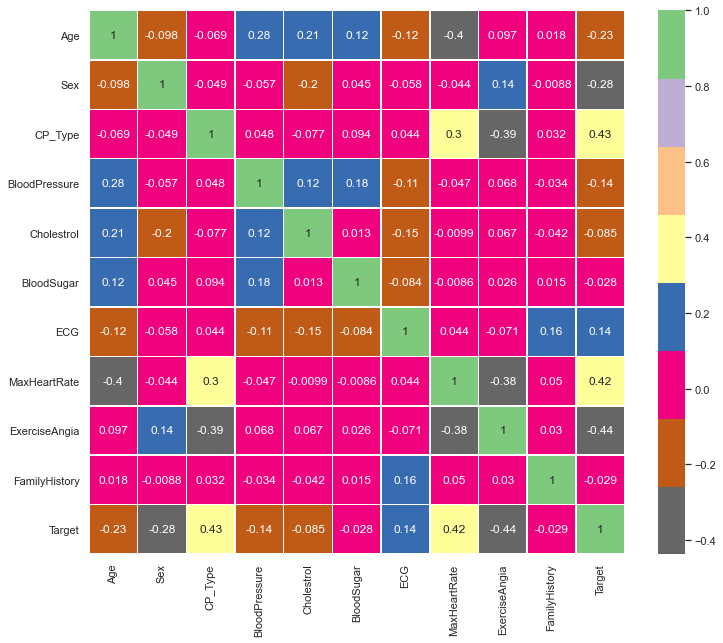

In [25]:
plt.figure(figsize=(12,10))
cor = data1.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Accent_r, linewidth=0.5)
plt.show()

In [26]:
#Function to prepare a set of highly correlated independent feature
def getCorrelatedFeature(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

##### Get list of correlated features having similarity level of 70%
##### Conclusion: No single feature identified in this correlation analysis as duplicate, all are important as per correaltion analysis

In [27]:
corr_features = getCorrelatedFeature(data1, 0.70)
len(set(corr_features)), corr_features

(0, set())

##### Checking data density

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F5B1B72700>,
      dtype=object)

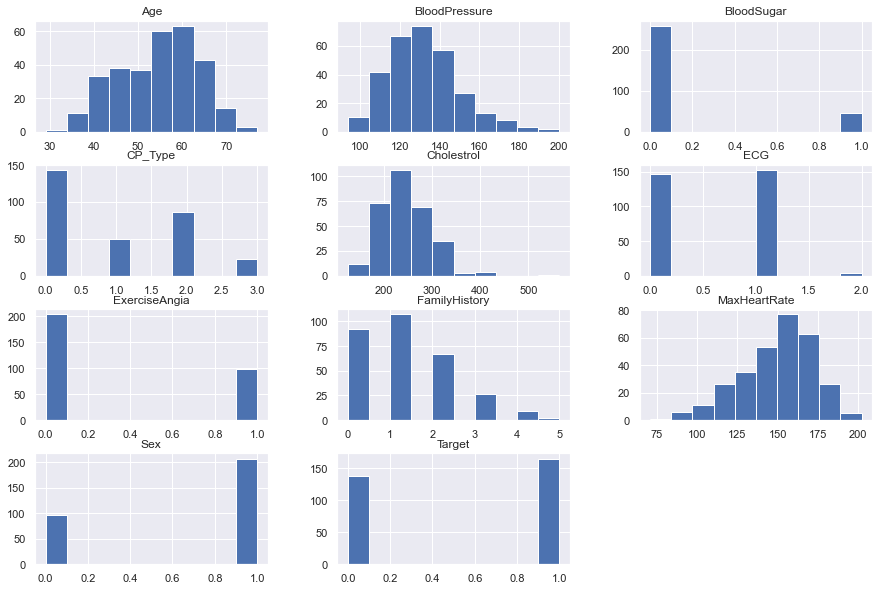

In [28]:
data1.hist(figsize=(15,10))

#### As there are no null values in data, we can proceed with the next steps to find outliers, detecting outliers using IQR (InterQuartile Range)

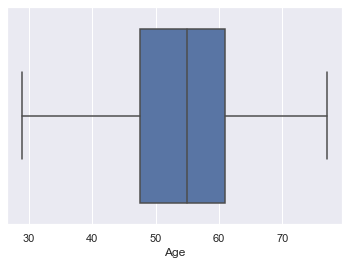

In [29]:
sns.boxplot(x=data1['Age'])

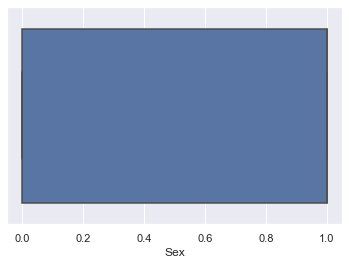

In [30]:
sns.boxplot(x=data1['Sex'])

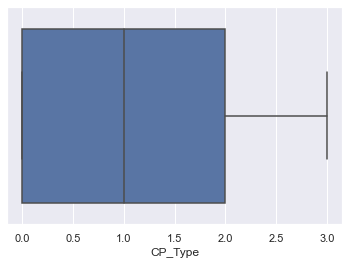

In [31]:
sns.boxplot(x=data1['CP_Type'])

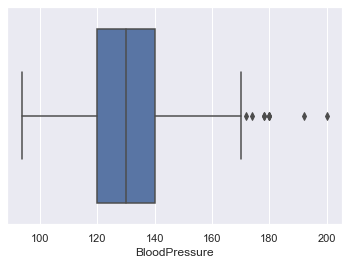

In [32]:
sns.boxplot(x=data1['BloodPressure'])

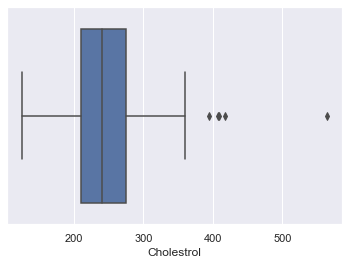

In [33]:
sns.boxplot(x=data1['Cholestrol'])

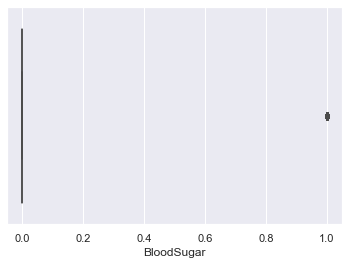

In [34]:
sns.boxplot(x=data1['BloodSugar'])

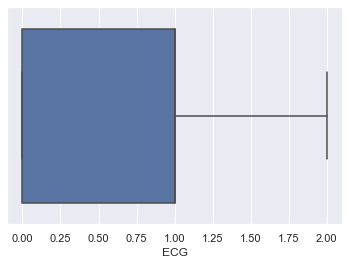

In [35]:
sns.boxplot(x=data1['ECG'])

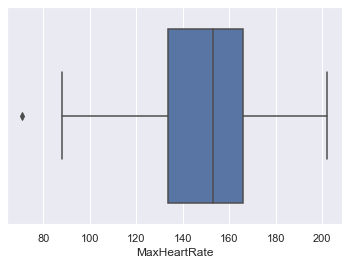

In [36]:
sns.boxplot(x=data1['MaxHeartRate']) 
#Outlier Present

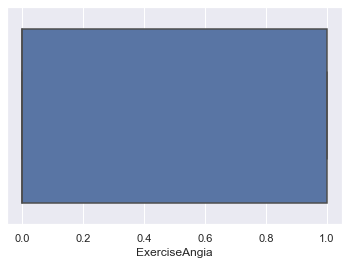

In [37]:
sns.boxplot(x=data1['ExerciseAngia'])

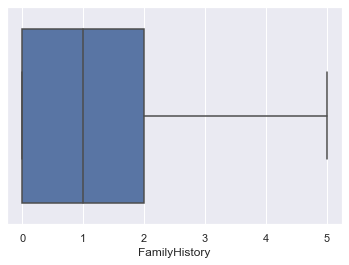

In [38]:
sns.boxplot(x=data1['FamilyHistory'])

In [39]:
#Find the InterQuartile Range
Q1 = data1.quantile(0.25)
Q3 = data1.quantile(0.75)
IQR = Q3-Q1
print('################ InterQuartile Range ###################')
print(IQR)
# Remove the outliers using IQR
data2 = data1[~((data1<(Q1-1.5*IQR))|(data1>(Q3+1.5*IQR))).any(axis=1)]
data2.shape

################ InterQuartile Range ###################
Age              13.5
Sex               1.0
CP_Type           2.0
BloodPressure    20.0
Cholestrol       63.5
BloodSugar        0.0
ECG               1.0
MaxHeartRate     32.5
ExerciseAngia     1.0
FamilyHistory     2.0
Target            1.0
dtype: float64


(248, 11)

## Data Preprocessing
##### Removing outliers using Z-score

In [40]:
z = np.abs(stats.zscore(data1))
data3 = data1[(z<3).all(axis=1)]
df=data3
print("Data Shape:", data3.shape)

Data Shape: (294, 11)


## Data Balancing
##### Analyzing the target variable to check data balancing
##### Conclusion: Approximately 45:55 ratio is there in target variable 

Data Balance Figures: Target
0    132
1    162
dtype: int64


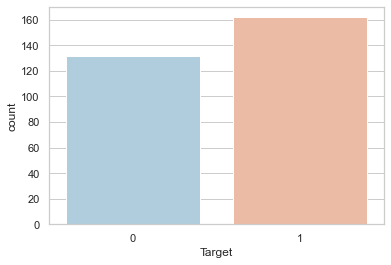

In [41]:
sns.set_style('whitegrid')
sns.countplot(x='Target', data=data3, palette='RdBu_r')

print("Data Balance Figures:", data3.groupby('Target').size())


## Data Preprocessing & Feature Engineering

##### After exploration it is observed that some features requires scaling before training the machine learning models, pd. get_dummies when applied to a column of categories where we have one category per observation will produce a new column (variable) for each unique categorical value. It will place a one in the column corresponding to the categorical value present for that observation. This is equivalent to one hot encoding

### Feature Engineering-1

In [42]:
dataset = pd.get_dummies(df, columns=['Sex', 'CP_Type', 'BloodSugar', 'ECG', 'ExerciseAngia'])
dataset.head()

,Age,BloodPressure,Cholestrol,MaxHeartRate,FamilyHistory,Target,Sex_0,Sex_1,CP_Type_0,CP_Type_1,CP_Type_2,CP_Type_3,BloodSugar_0,BloodSugar_1,ECG_0,ECG_1,ECG_2,ExerciseAngia_0,ExerciseAngia_1
0,63,145,233,150,2,1,0,1,0,0,0,1,0,1,1,0,0,1,0
1,37,130,250,187,1,1,0,1,0,0,1,0,1,0,0,1,0,1,0
2,41,130,204,172,0,1,1,0,0,1,0,0,1,0,1,0,0,1,0
3,56,120,236,178,1,1,0,1,0,1,0,0,1,0,0,1,0,1,0
4,57,120,354,163,0,1,1,0,1,0,0,0,1,0,0,1,0,0,1


##### Performoring scaling on mentioned features below

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# StandardScaler removes the mean and scales each feature/variable to unit variance.
stdSlr = StandardScaler()
col_to_scale = ['Age', 'BloodPressure', 'Cholestrol', 'MaxHeartRate', 'FamilyHistory']
print(col_to_scale)
dataset[col_to_scale] = stdSlr.fit_transform(dataset[col_to_scale])
dataset.head()

['Age', 'BloodPressure', 'Cholestrol', 'MaxHeartRate', 'FamilyHistory']


,Age,BloodPressure,Cholestrol,MaxHeartRate,FamilyHistory,Target,Sex_0,Sex_1,CP_Type_0,CP_Type_1,CP_Type_2,CP_Type_3,BloodSugar_0,BloodSugar_1,ECG_0,ECG_1,ECG_2,ExerciseAngia_0,ExerciseAngia_1
0,0.966588,0.815804,-0.225595,0.013590,0.787150,1,0,1,0,0,0,1,0,1,1,0,0,1,0
1,-1.893884,-0.077146,0.144206,1.656210,-0.165204,1,0,1,0,0,1,0,1,0,0,1,0,1,0
2,-1.453811,-0.077146,-0.856431,0.990283,-1.117559,1,1,0,0,1,0,0,1,0,1,0,0,1,0
3,0.196461,-0.672446,-0.160336,1.256654,-0.165204,1,0,1,0,1,0,0,1,0,0,1,0,1,0
4,0.306479,-0.672446,2.406515,0.590727,-1.117559,1,1,0,1,0,0,0,1,0,0,1,0,0,1


In [44]:
print("Feature selected using correlation after preprocessing and FE:")
dataset.columns

Feature selected using correlation after preprocessing and FE:


Index(['Age', 'BloodPressure', 'Cholestrol', 'MaxHeartRate', 'FamilyHistory',
       'Target', 'Sex_0', 'Sex_1', 'CP_Type_0', 'CP_Type_1', 'CP_Type_2',
       'CP_Type_3', 'BloodSugar_0', 'BloodSugar_1', 'ECG_0', 'ECG_1', 'ECG_2',
       'ExerciseAngia_0', 'ExerciseAngia_1'],
      dtype='object')

### Feature Engineering-2 

In [45]:
data3.head()

,Age,Sex,CP_Type,BloodPressure,Cholestrol,BloodSugar,ECG,MaxHeartRate,ExerciseAngia,FamilyHistory,Target
0,63,1,3,145,233,1,0,150,0,2,1
1,37,1,2,130,250,0,1,187,0,1,1
2,41,0,1,130,204,0,0,172,0,0,1
3,56,1,1,120,236,0,1,178,0,1,1
4,57,0,0,120,354,0,1,163,1,0,1


In [46]:
average_fh_age = data3.groupby('FamilyHistory')['Age'].mean().reset_index(name='average_fh_age')
average_fh_bp = data3.groupby('FamilyHistory')['BloodPressure'].mean().reset_index(name='average_fh_bp')

cp_med_age = data3.groupby('CP_Type')['Age'].median().reset_index(name='cp_med_age')
cp_average_bp = data3.groupby('CP_Type')['BloodPressure'].mean().reset_index(name='cp_average_bp')
cp_average_chol = data3.groupby('CP_Type')['Cholestrol'].median().reset_index(name='cp_average_chol')

average_bs_bp = data3.groupby('BloodSugar')['BloodPressure'].mean().reset_index(name='average_bs_bp')

med_ecg_age = data3.groupby('ECG')['Age'].median().reset_index(name='med_ecg_age')
average_ecg_bp = data3.groupby('ECG')['BloodPressure'].mean().reset_index(name='average_ecg_bp')
average_ecg_chol = data3.groupby('ECG')['Cholestrol'].mean().reset_index(name='average_ecg_chol')

average_ecg_heartrate = data3.groupby('ECG')['MaxHeartRate'].mean().reset_index(name='average_ecg_heartrate')


In [47]:
average_fh_age_df = pd.DataFrame(average_fh_age)
result = pd.merge(data3, average_fh_age_df, on=['FamilyHistory'], how='left')
result = pd.merge(result, average_fh_bp, on=['FamilyHistory'], how='left')
result = pd.merge(result, cp_med_age, on=['CP_Type'], how='left')
result = pd.merge(result, cp_average_bp, on=['CP_Type'], how='left')
result = pd.merge(result, cp_average_chol, on=['CP_Type'], how='left')
result = pd.merge(result, average_bs_bp, on=['BloodSugar'], how='left')
result = pd.merge(result, med_ecg_age, on=['ECG'], how='left')
result = pd.merge(result, average_ecg_bp, on=['ECG'], how='left')
result = pd.merge(result, average_ecg_chol, on=['ECG'], how='left')
result = pd.merge(result, average_ecg_heartrate, on=['ECG'], how='left')

result

,Age,Sex,CP_Type,BloodPressure,Cholestrol,BloodSugar,ECG,MaxHeartRate,ExerciseAngia,FamilyHistory,...,average_fh_age,average_fh_bp,cp_med_age,cp_average_bp,cp_average_chol,average_bs_bp,med_ecg_age,average_ecg_bp,average_ecg_chol,average_ecg_heartrate
0,63,1,3,145,233,1,0,150,0,2,...,54.318182,128.818182,59,140.869565,234,137.627907,57.0,133.185714,249.142857,147.514286
1,37,1,2,130,250,0,1,187,0,1,...,53.359223,131.679612,53,130.447059,233,130.211155,53.5,129.286667,237.493333,152.366667
2,41,0,1,130,204,0,0,172,0,0,...,54.516484,132.505495,52,127.562500,238,130.211155,57.0,133.185714,249.142857,147.514286
3,56,1,1,120,236,0,1,178,0,1,...,53.359223,131.679612,52,127.562500,238,130.211155,53.5,129.286667,237.493333,152.366667
4,57,0,0,120,354,0,1,163,1,0,...,54.516484,132.505495,57,131.521739,247,130.211155,53.5,129.286667,237.493333,152.366667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,57,0,0,140,241,0,1,123,1,0,...,54.516484,132.505495,57,131.521739,247,130.211155,53.5,129.286667,237.493333,152.366667
290,45,1,3,110,264,0,1,132,0,0,...,54.516484,132.505495,59,140.869565,234,130.211155,53.5,129.286667,237.493333,152.366667
291,68,1,0,144,193,1,1,141,0,0,...,54.516484,132.505495,57,131.521739,247,137.627907,53.5,129.286667,237.493333,152.366667
292,57,1,0,130,131,0,1,115,1,0,...,54.516484,132.505495,57,131.521739,247,130.211155,53.5,129.286667,237.493333,152.366667


In [48]:
#Check duplicate rows in data
duplicate_rows = result[result.duplicated()]
print("Number of duplicate rows :: ", duplicate_rows.shape)
#looking for null values
print("Null values")
print(result.isnull() .sum())
#Explore if the other data is consistent
print("data shape:\n" , result.shape)
print("data columns:\n" ,result.columns)

Number of duplicate rows ::  (0, 21)
Null values
Age                      0
Sex                      0
CP_Type                  0
BloodPressure            0
Cholestrol               0
BloodSugar               0
ECG                      0
MaxHeartRate             0
ExerciseAngia            0
FamilyHistory            0
Target                   0
average_fh_age           0
average_fh_bp            0
cp_med_age               0
cp_average_bp            0
cp_average_chol          0
average_bs_bp            0
med_ecg_age              0
average_ecg_bp           0
average_ecg_chol         0
average_ecg_heartrate    0
dtype: int64
data shape:
 (294, 21)
data columns:
 Index(['Age', 'Sex', 'CP_Type', 'BloodPressure', 'Cholestrol', 'BloodSugar',
       'ECG', 'MaxHeartRate', 'ExerciseAngia', 'FamilyHistory', 'Target',
       'average_fh_age', 'average_fh_bp', 'cp_med_age', 'cp_average_bp',
       'cp_average_chol', 'average_bs_bp', 'med_ecg_age', 'average_ecg_bp',
       'average_ecg_chol', 'avera

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F5B1A294C0>,
      dtype=object)

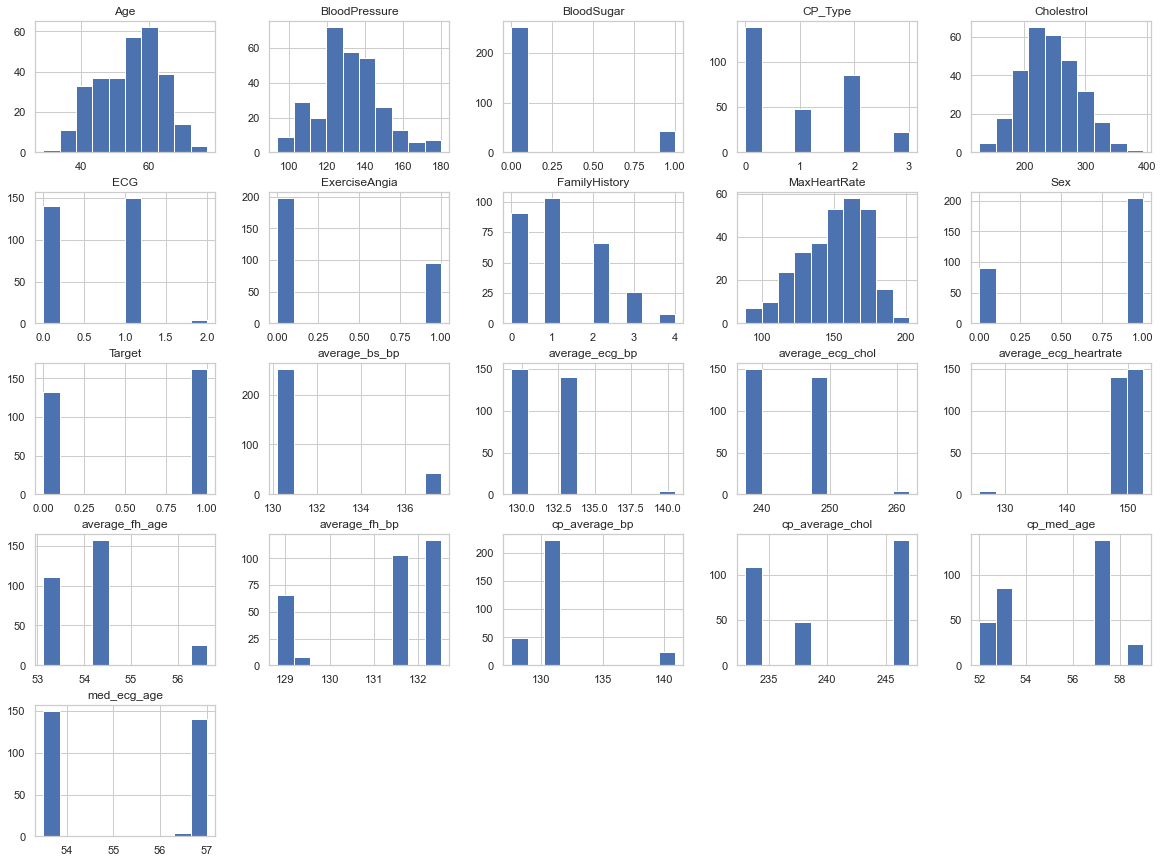

In [49]:
result.hist(figsize=(20,15))

##### Data scaling performed because the data existing on multiple scale

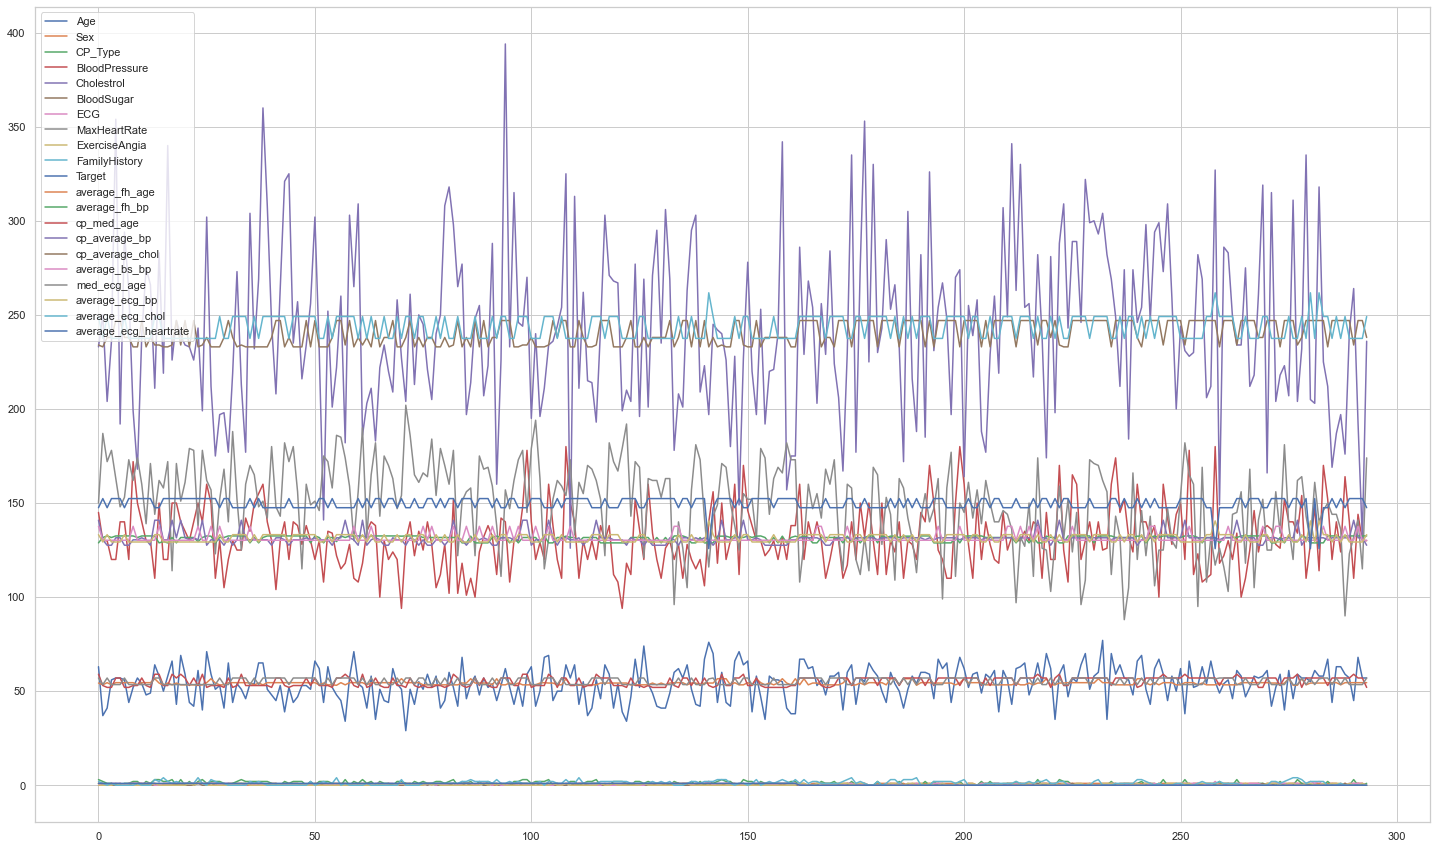

In [50]:
result.plot(figsize=(25, 15))

In [51]:
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
scaled_df = pd.DataFrame(scalar.fit_transform(result), columns=result.columns)
result = scaled_df
result.head(5)

,Age,Sex,CP_Type,BloodPressure,Cholestrol,BloodSugar,ECG,MaxHeartRate,ExerciseAngia,FamilyHistory,...,average_fh_age,average_fh_bp,cp_med_age,cp_average_bp,cp_average_chol,average_bs_bp,med_ecg_age,average_ecg_bp,average_ecg_chol,average_ecg_heartrate
0,0.708333,1.0,1.000000,0.593023,0.399254,1.0,0.0,0.543860,0.0,0.50,...,0.341848,0.00000,1.000000,1.000000,0.071429,1.0,1.0,0.347715,0.480261,0.817694
1,0.166667,1.0,0.666667,0.418605,0.462687,0.0,0.5,0.868421,0.0,0.25,...,0.067105,0.77602,0.142857,0.216769,0.000000,0.0,0.0,0.000000,0.000000,1.000000
2,0.250000,0.0,0.333333,0.418605,0.291045,0.0,0.0,0.736842,0.0,0.00,...,0.398662,1.00000,0.000000,0.000000,0.357143,0.0,1.0,0.347715,0.480261,0.817694
3,0.562500,1.0,0.333333,0.302326,0.410448,0.0,0.5,0.789474,0.0,0.25,...,0.067105,0.77602,0.000000,0.000000,0.357143,0.0,0.0,0.000000,0.000000,1.000000
4,0.583333,0.0,0.000000,0.302326,0.850746,0.0,0.5,0.657895,1.0,0.00,...,0.398662,1.00000,0.714286,0.297529,1.000000,0.0,0.0,0.000000,0.000000,1.000000


In [52]:
# To be used to store accuracy and plotting a graph for better visualization
classifications_scores = {}

# Random Forest Classifier

#### Feature Engineering-1: Train test split

In [53]:
y = dataset["Target"]
x = dataset.drop("Target", axis=1)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

##### Random forest: Hypertuning

In [54]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [55]:
#Finding hyper tune parameters for random forest classification
LR = {'n_estimators': [100,150, 200,250], 'max_depth':[1,2,3], 'max_features':[0.3,0.4,0.5]}
tuning = GridSearchCV(estimator=RandomForestClassifier(), param_grid=LR)
tuning.fit(x_train, y_train)
tuning.best_params_, tuning.best_score_

({'max_depth': 3, 'max_features': 0.3, 'n_estimators': 100}, 0.775609756097561)

#### Classification and fitting using random forest on data processed and prepared after Feature engineering-1 

In [56]:
# Using Random forest classifier
rfc = RandomForestClassifier(n_estimators=150, max_features=0.5, max_depth=3)
rfc.fit(x_train,y_train)
y_pred = rfc.predict(x_test)
print("Accuracy of Random Forest Classifier :: ", metrics.accuracy_score(y_test, y_pred))

Accuracy of Random Forest Classifier ::  0.7303370786516854


##### Relative important features for the data set generated after FE1 

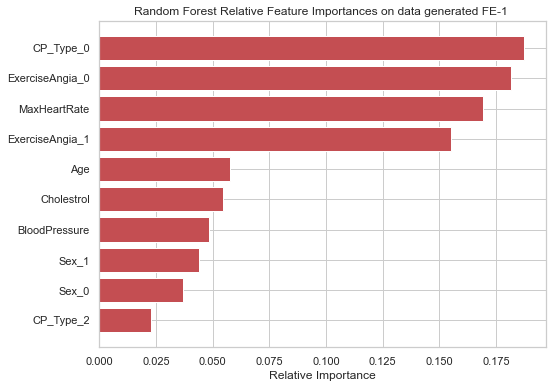

In [57]:
#Exploring top important features 
import numpy as np
features=x_train.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (8,6))
plt.title('Random Forest Relative Feature Importances on data generated FE-1 ')
plt.barh(range(len(indices[-10:])), importances[indices[-10:]], color='r', align='center')
plt.yticks(range(len(indices[-10:])), features[indices[-10:]])
plt.xlabel('Relative Importance');

##### Model accuracy, classification and confusion matrix using FE-1

In [58]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
#Generating confusion matrix
print("FE1-Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
#Finding accuracy
print("FE-1 Random Forest Accuracy:",metrics.accuracy_score(y_test, y_pred))
classifications_scores['FE1+ML1-RandomForest'] = metrics.accuracy_score(y_test, y_pred);
#Generate classification report
print("FE-1 Random ForestClassification Report:\n", classification_report(y_test, y_pred))

FE1-Random Forest Confusion Matrix:
 [[22 18]
 [ 6 43]]
FE-1 Random Forest Accuracy: 0.7303370786516854
FE-1 Random ForestClassification Report:
               precision    recall  f1-score   support

           0       0.79      0.55      0.65        40
           1       0.70      0.88      0.78        49

    accuracy                           0.73        89
   macro avg       0.75      0.71      0.71        89
weighted avg       0.74      0.73      0.72        89



### Classification and fitting using random forest on data processed and prepared after Feature engineering-2 
#### Feature Engineering-2: Train test split

In [59]:
fe2_y = result["Target"]
fe2_x = result.drop("Target", axis=1)
fe2_x_train,fe2_x_test,fe2_y_train,fe2_y_test = train_test_split(fe2_x,fe2_y,test_size=0.3)


##### Hypertuning for reandom forest for Feature Engineering-2 dataset

In [60]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
#Finding hyper tune parameters for random forest classification
LR = {'n_estimators': [100,150, 200,250], 'max_depth':[1,2,3], 'max_features':[0.3,0.4,0.5]}
tuning = GridSearchCV(estimator=RandomForestClassifier(), param_grid=LR)
tuning.fit(fe2_x_train, fe2_y_train)
tuning.best_params_, tuning.best_score_

({'max_depth': 1, 'max_features': 0.3, 'n_estimators': 200}, 0.751219512195122)

#### Classification and fitting using random forest on data processed and prepared after Feature engineering-2 

In [61]:
# Using Random forest classifier
fe2_rfc = RandomForestClassifier(n_estimators=200, max_features=0.5, max_depth=3)
fe2_rfc.fit(fe2_x_train,fe2_y_train)
fe2_y_pred = fe2_rfc.predict(fe2_x_test)
print("Accuracy of Random Forest Classifier :: ", metrics.accuracy_score(fe2_y_test, fe2_y_pred))


Accuracy of Random Forest Classifier ::  0.7865168539325843


##### Relative important features for the data set generated after FE2 

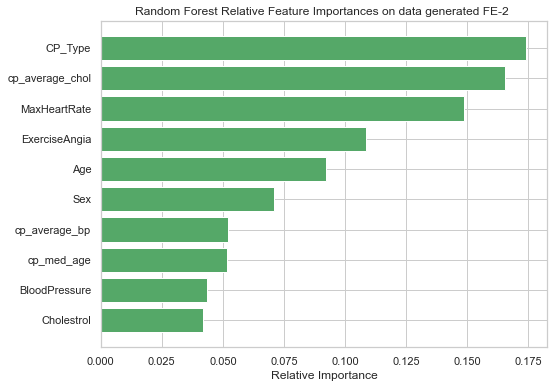

In [62]:
#Exploring top important features 
import numpy as np
features=fe2_x_train.columns
importances = fe2_rfc.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize = (8,6))
plt.title('Random Forest Relative Feature Importances on data generated FE-2 ')
plt.barh(range(len(indices[-10:])), importances[indices[-10:]], color='g', align='center')
plt.yticks(range(len(indices[-10:])), features[indices[-10:]])
plt.xlabel('Relative Importance');

##### Model accuracy, classification and confusion matrix using FE-2

In [63]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
#Generating confusion matrix
print("FE-2-Random Forest Confusion Matrix:\n", confusion_matrix(fe2_y_test, fe2_y_pred))
#Finding accuracy
print("FE-2 Random Forest Accuracy:",metrics.accuracy_score(fe2_y_test, fe2_y_pred))
classifications_scores['FE2+ML1-RandomForest'] = metrics.accuracy_score(fe2_y_test, fe2_y_pred)
#Generate classification report
print("FE-2 Random Forest Classification Report:\n", classification_report(fe2_y_test, fe2_y_pred))

FE-2-Random Forest Confusion Matrix:
 [[34 13]
 [ 6 36]]
FE-2 Random Forest Accuracy: 0.7865168539325843
FE-2 Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.72      0.78        47
         1.0       0.73      0.86      0.79        42

    accuracy                           0.79        89
   macro avg       0.79      0.79      0.79        89
weighted avg       0.80      0.79      0.79        89



## Gradient Boosting Classfication

##### Gradient Boosting: Train test split FE-1 

In [64]:
from sklearn.model_selection import train_test_split
#Note: X & y used from above which refers to same dataset used for random forest
Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=0)
Xtrain.shape, Xtest.shape

((205, 18), (89, 18))

##### Gradient Boosting Hypertuning

In [65]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [66]:
#Finding hyper tune parameters for boosting classification
LR = {'learning_rate': [0.15, 0.1, 0.10, 0.05], 'n_estimators': [100,150, 200], 'max_depth':[1,2]}
tuning = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=LR)
tuning.fit(Xtrain, ytrain)
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 100},
 0.7707317073170732)

#### Classification and fitting using gradient boosting on FE-1

In [67]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=1)
gbc.fit(Xtrain, ytrain)
gbc.score(Xtest, ytest)

0.797752808988764

#### Relative important feature for gradient boosting on FE1

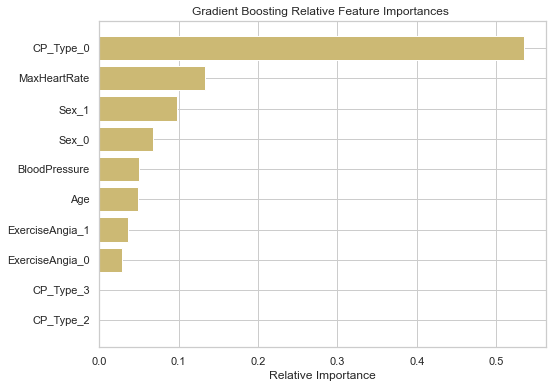

In [68]:
#Exploring top important features 
import numpy as np
features=Xtrain.columns
importances = gbc.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (8,6))
plt.title('Gradient Boosting Relative Feature Importances ')
plt.barh(range(len(indices[-10:])), importances[indices[-10:]], color='y', align='center')
plt.yticks(range(len(indices[-10:])), features[indices[-10:]])
plt.xlabel('Relative Importance');

In [69]:
ypred=gbc.predict(Xtest)
ypred

array([0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0], dtype=int64)

##### Model accuracy, classification and confusion matrix using FE-1

In [70]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
# Model Accuracy, how often is the classifier correct?
print("FE-1 Gradient Boosting Accuracy:",metrics.accuracy_score(ytest, ypred))
classifications_scores['FE1+ML2-GradientBoosting'] = metrics.accuracy_score(ytest, ypred)
# #Generating confusion matrix
print("FE-1 Gradient Boosting Confusion Matrix:\n",confusion_matrix(ytest, ypred))
print("FE-1 Gradient Boosting Classification Report:\n",classification_report(ytest, ypred))

FE-1 Gradient Boosting Accuracy: 0.797752808988764
FE-1 Gradient Boosting Confusion Matrix:
 [[33 11]
 [ 7 38]]
FE-1 Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.75      0.79        44
           1       0.78      0.84      0.81        45

    accuracy                           0.80        89
   macro avg       0.80      0.80      0.80        89
weighted avg       0.80      0.80      0.80        89



#### Classification and fitting using gradient boosting on FE-2


In [71]:
from sklearn.model_selection import train_test_split
fe2y = result["Target"]
fe2x = result.drop("Target", axis=1)
fe2Xtrain, fe2Xtest, fe2ytrain, fe2ytest = train_test_split(fe2x, fe2y, test_size=0.3, random_state=0)
fe2Xtrain.shape, fe2Xtest.shape

((205, 20), (89, 20))

#### Gradient Boosting Hypertuning on FE2 data

In [72]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

#Finding hyper tune parameters for boosting classification
LR = {'learning_rate': [0.15, 0.1, 0.10, 0.05], 'n_estimators': [100,150, 200], 'max_depth':[1,2]}
tuning = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=LR)
tuning.fit(fe2Xtrain, fe2ytrain)
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 100},
 0.7707317073170732)

#### Classification using gradient boosting on FE2

In [73]:
fe2_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=1)
fe2_gbc.fit(fe2Xtrain, fe2ytrain)
fe2_gbc.score(fe2Xtest, fe2ytest)

0.797752808988764

#### Relative Important feature on FE2 dataset

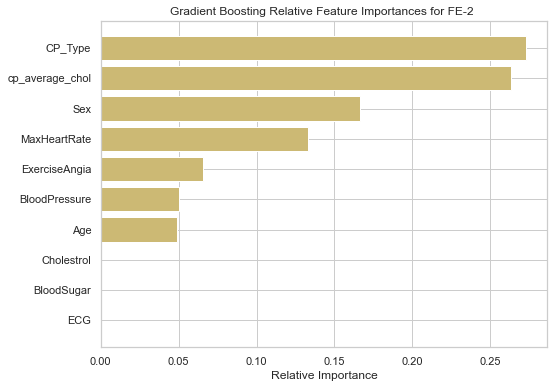

In [74]:
#Exploring top important features 
import numpy as np
features=fe2Xtrain.columns
importances = fe2_gbc.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (8,6))
plt.title('Gradient Boosting Relative Feature Importances for FE-2 ')
plt.barh(range(len(indices[-10:])), importances[indices[-10:]], color='y', align='center')
plt.yticks(range(len(indices[-10:])), features[indices[-10:]])
plt.xlabel('Relative Importance');

In [75]:
fe2ypred=fe2_gbc.predict(fe2Xtest)
fe2ypred


array([0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
       1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1.,
       0., 0., 1., 0.])

##### Model accuracy, classification and confusion matrix using FE-2

In [76]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
# Model Accuracy, how often is the classifier correct?
print("FE-2 Gradient Boosting Accuracy:",metrics.accuracy_score(fe2ytest, fe2ypred))
classifications_scores['FE2+ML2-GradientBoosting'] = metrics.accuracy_score(fe2ytest, fe2ypred)
# #Generating confusion matrix
print("FE-2 Gradient Boosting Confusion Matrix:\n",confusion_matrix(fe2ytest, fe2ypred))
print("FE-2 Gradient Boosting Classification Report:\n",classification_report(fe2ytest, fe2ypred))

FE-2 Gradient Boosting Accuracy: 0.797752808988764
FE-2 Gradient Boosting Confusion Matrix:
 [[33 11]
 [ 7 38]]
FE-2 Gradient Boosting Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.75      0.79        44
         1.0       0.78      0.84      0.81        45

    accuracy                           0.80        89
   macro avg       0.80      0.80      0.80        89
weighted avg       0.80      0.80      0.80        89



### Classifiers Results & Comparison

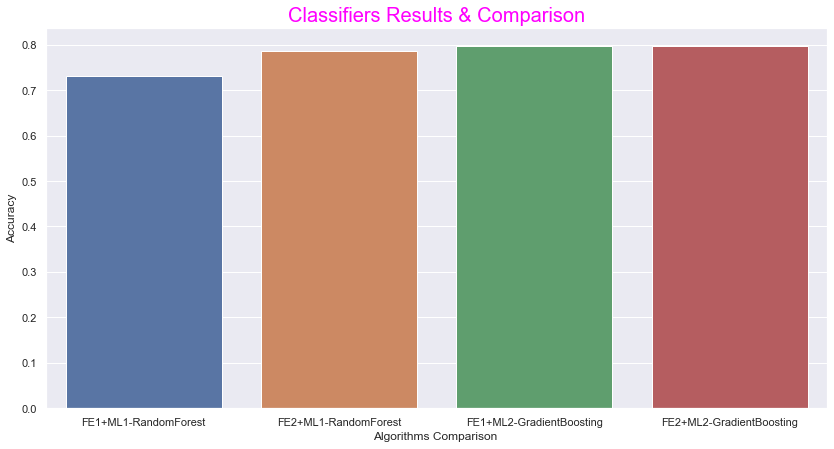

In [78]:
plt.title(label="Classifiers Results & Comparison",
          fontsize=20,
          color="magenta")
with sns.color_palette('muted'):
  classifier_name = list(classifications_scores.keys())
  accuracy_score = list(classifications_scores.values())
 
  sns.set(rc={'figure.figsize':(14,7)})
  plt.xlabel("Algorithms Comparison ")
  plt.ylabel("Accuracy")

  sns.barplot(classifier_name,accuracy_score)